In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (16, 8)

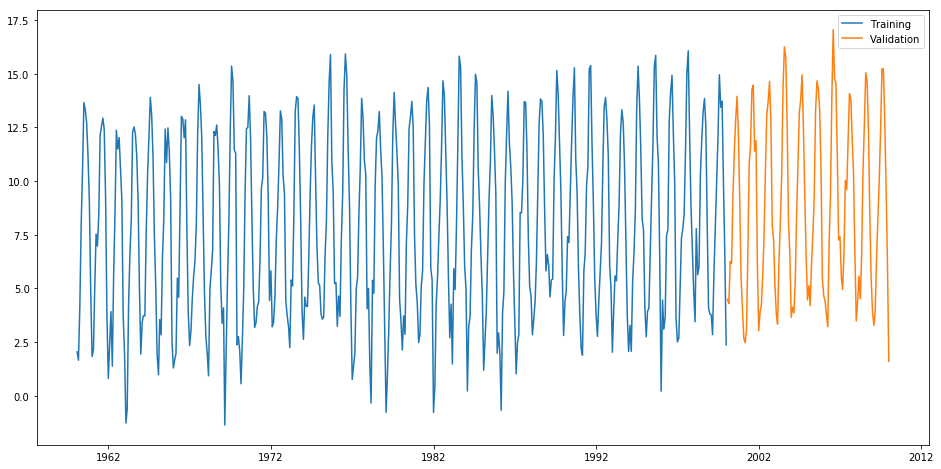

In [4]:
# Parse date strings as datetime objects
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')

# Read datafile
data = pd.read_csv('data/TG_STAID001825.txt', 
                    header=15,
                    usecols=[2, 3, 4],
                    names=["Date","Temp","Valid"],
                    parse_dates=["Date"], date_parser=dateparse,
                    index_col="Date")

# Prune data so we only consider 'valid' measurements
data = data[data.Valid == 0]
# Scale the temperature readings so units are degC
data.Temp = data.Temp * 0.1
# Resample the data so we have one sample a month 
data = data.resample("M").mean() 

# Use data from 1960 - 2000 to train and 2000 - 2010 to validate
training_data = data.loc['1960-01-01':'2000-01-01']
validation_data = data.loc['2000-01-01':'2010-01-01']

# Make a series object from the data, will be indexed by date
train = training_data["Temp"]
valid = validation_data["Temp"]

plt.plot(train,label="Training")
plt.plot(valid,label="Validation")
plt.legend(loc='best')

In [5]:
# A helper function for calculating the stationality of a dataset
from statsmodels.tsa.stattools import adfuller
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 

    # Print Summary
    print "Augmented Dickey-Fuller Test on {0}".format(name)
    print '-'*47
    print "Null Hypothesis: Data has unit root. Non-Stationary."
    print "Significance Level    = {0:.3f}".format(signif)
    print "Test Statistic        = {0:.3f}".format(output["test_statistic"])
    print "No. Lags Chosen       = {0:.1f}".format(output["n_lags"])

    for key,val in r[4].items():
        print "Critical value {0} = {1:.3f}".format(key, val)

    if p_value <= signif:
        print "=> P-Value = {0:.3e}. Rejecting Null Hypothesis.".format(p_value)
        print '-'*30
        print "=> Series is Stationary."
    else:
        print "=> P-Value = {0:.3f}. Weak evidence to reject the Null Hypothesis."
        print '-'*30
        print "=> Series is Non-Stationary."
    print '-'*30


In [6]:
adfuller_test(train)

Augmented Dickey-Fuller Test on 
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level    = 0.050
Test Statistic        = -3.280
No. Lags Chosen       = 14.0
Critical value 5% = -2.868
Critical value 1% = -3.444
Critical value 10% = -2.570
=> P-Value = 1.580e-02. Rejecting Null Hypothesis.
------------------------------
=> Series is Stationary.
------------------------------


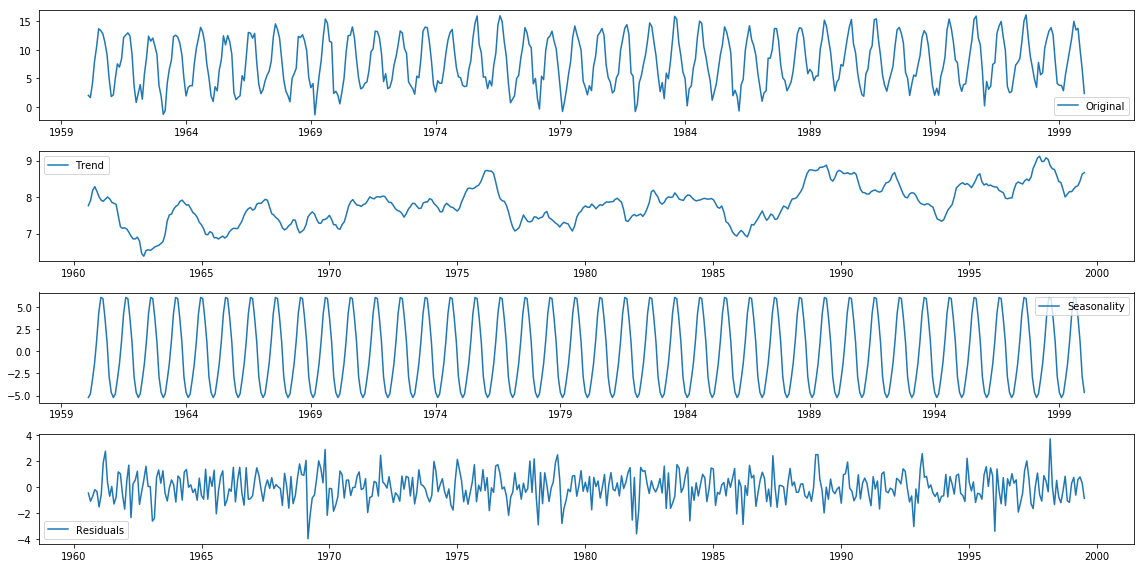

In [7]:
# Further checks of trend and seasonality
#
#
# Try decomposing the trend and seasonality so we
# can remove them from the model.
from statsmodels.tsa.seasonal import seasonal_decompose
periodicity = 12 # Months
decomposition = seasonal_decompose(train, freq=periodicity)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,8))
plt.subplot(411)
plt.plot(train, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [8]:
#####################################################
# We can see from the above the this dataset has
# a clear periodic seasonailty. When we decompose 
# that from the signal we can make the data even
# more stationary (see p-value).
#####################################################
train_decompose = residual
train_decompose.dropna(inplace=True) # Remove nans
adfuller_test(train_decompose)

Augmented Dickey-Fuller Test on 
-----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level    = 0.050
Test Statistic        = -11.158
No. Lags Chosen       = 14.0
Critical value 5% = -2.868
Critical value 1% = -3.445
Critical value 10% = -2.570
=> P-Value = 0.000e+00. Rejecting Null Hypothesis.
------------------------------
=> Series is Stationary.
------------------------------


/Users/leming/venv/lib/python2.7/site-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 12); AIC=1644.131, BIC=1677.521, Fit time=3.049 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=2757.836, BIC=2766.183, Fit time=0.024 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=1839.272, BIC=1855.967, Fit time=0.821 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=2176.722, BIC=2193.417, Fit time=0.346 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 1, 12); AIC=1651.288, BIC=1680.504, Fit time=2.325 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 0, 1, 12); AIC=1645.092, BIC=1682.656, Fit time=5.617 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 0, 12); AIC=1807.932, BIC=1837.149, Fit time=1.298 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 2, 12); AIC=1646.232, BIC=1683.796, Fit time=7.452 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 12); AIC=1664.628, BIC=1689.671, Fit time=0.607 seconds
Fit ARIMA: order=(2, 0, 2) s

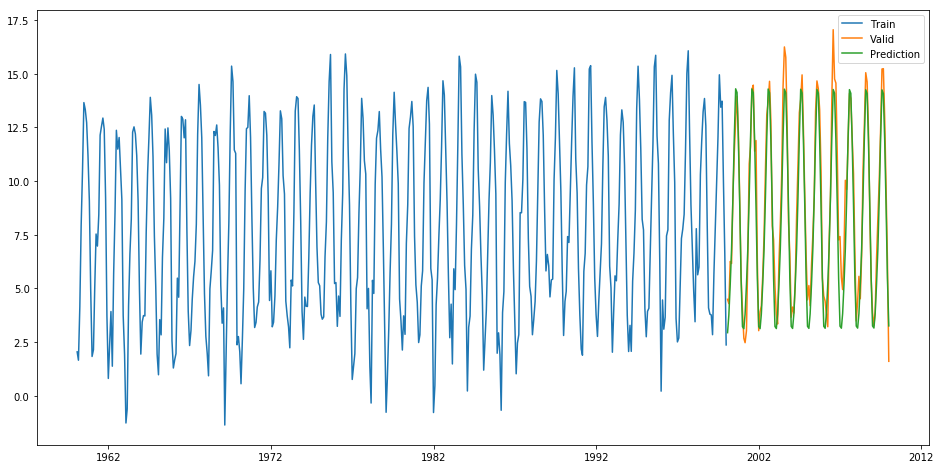

In [9]:
# Now we're convinced we have a time series with a seasonal component
# we can use a seasonal ARIMA model to make our predictions
#
# Use the Auto ARIMA class to build a model and minimise the parameters
from pyramid.arima import auto_arima
model = auto_arima(train,                      # Dataset
                   trace=True,                 # print status during fit
                   error_action='ignore',      # ignore errors
                   suppress_warnings=True,     # no warning printing
                   seasonal=True,              # This is a seasonal dataset
                   m=periodicity)              # no. observations per seasonal cycle

# ARIMA forcasting has three input (hyper) parameters: 
# Number of Auto-regressive terms (p)
# Number of differences (d) 
# Number of moving average terms (q)
# You'll see these represented by the 'order' tuple when we run the next line
model.fit(train)
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast, index=valid.index, columns=['Temp'])

# plot the predictions and validation set
plt.plot(train, label='Train')
plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.legend(loc='best')
plt.show()


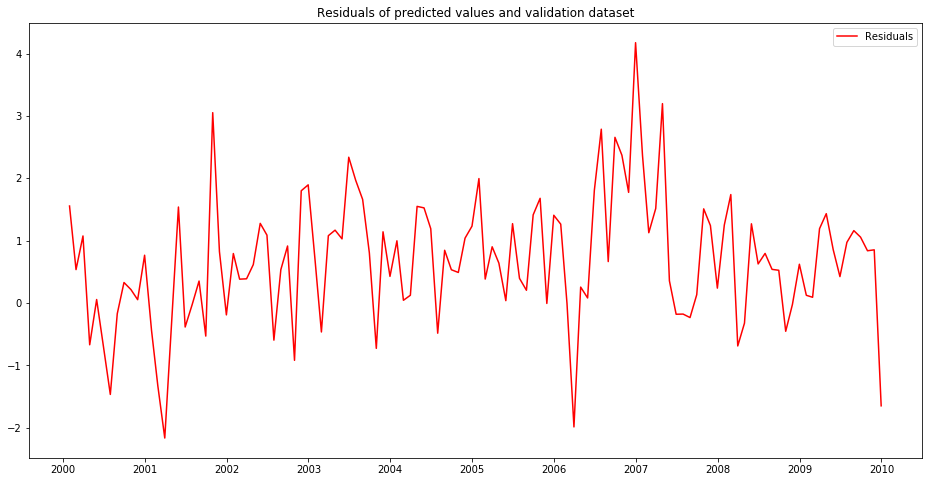

Monthly average temperature predictor has RMSE = 1.223 over 10 years of forcasting


In [10]:
# Plot the residuals between validation data set and prediction
plt.plot(valid.index, valid-forecast.Temp, color="red", label='Residuals')
plt.title("Residuals of predicted values and validation dataset")
plt.legend(loc='best')
plt.show()

import sklearn.metrics
rms = np.sqrt(sklearn.metrics.mean_squared_error(valid, forecast.Temp))
print "Monthly average temperature predictor has RMSE = {0:.3f} over 10 years of forcasting".format(rms)